# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 5: Modelo final

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Horacio Martinez Alfaro  – Profesor Tutor

#### **Miembros del equipo:**
 - Jose Luis Artigas Arroyo - A01794906
 - José Luis Fabela Portillo - A00748551
 - Alejandro Emmanuel Silva Ortega - A01794545

En esta fase del proyecto de evaluara el modelo final seleccionado, el cual fur Desicion Tree Classifier. Para evaluar este modelo se usaran los datos de la base de datos de DCTPep con péptidos que atacan a la molecula VEGF.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
import joblib
from preprocess import pfeature_process
import csv
import torch
import yaml
import sys
sys.path.insert(1, '../')
from models.network import create_model

In [3]:
#ubicacion de los archivos de datos con el modelo y el archivo FASTA procesado con CD-HIT
model_path = '../models/dtr_model.pkl'
cd_hit_path = '../data/processed/VEGF.txt'

In [4]:
model = joblib.load(model_path)

In [5]:
vegf_seqs = pfeature_process(cd_hit_path)

TypeError: pfeature_process() missing 1 required positional argument: 'file_path'

In [6]:
vegf_predict = model.predict(vegf_seqs)
vegf_predict

array([0, 1, 0, ..., 0, 0, 0])

In [9]:
vegf_y = pd.read_csv('../data/processed/VEGF_y.csv')

In [ ]:
vegf_report = classification_report(vegf_y, vegf_predict, target_names=['positive','negative'])


In [13]:
print(vegf_report)

# Procesamiento de secuencias generadas para clasificarla como potencialmente 

In [ ]:
cd_hit_path = '../data/processed/generated_seqs_cd_hit.txt'


In [1]:
test_seqs = pfeature_process(cd_hit_path)
test_seqs


NameError: name 'pfeature_process' is not defined

In [8]:
predict_test = model.predict(test_seqs)
predict_test

array([1, 0, 0, ..., 0, 0, 0])

In [9]:
predict_test = pd.DataFrame(predict_test)

In [10]:
predict_test.index = test_seqs.index
predict_test.reset_index(inplace=True)
predict_test.shape

(1365, 2)

In [11]:
predict_test.rename(columns={'index':'Secuence', 0:'Label'}, inplace=True)



In [12]:
predict_test

,Secuence,Label
0,LDLDDWYTVDRDAMSM,1
1,KEAKEGATEWCPIVIN,0
2,IYMYQNPQADYQKTVV,0
3,YYIENVMHVAMPMYYK,1
4,DPAMEFDNAEIIDDDD,0
...,...,...
1360,YVYMMYYMYMVRMCHD,0
1361,DNKHYYDYDTKFNYVV,1
1362,WEHEQQHDNQDDGKDN,0
1363,YYCIMNKMTDKHFFAA,0


In [13]:
predict_positive = predict_test[predict_test['Label']==1]
predict_positive

,Secuence,Label
0,LDLDDWYTVDRDAMSM,1
3,YYIENVMHVAMPMYYK,1
6,YMMMDEMCQMYPTSQA,1
11,NRQRNSNGVAMSGTAT,1
16,EYDYIPPPHHHRNKNI,1
...,...,...
1349,NDRIIGNQVEIICVVC,1
1352,IHRFHYLPLPQKNSEE,1
1355,EIQSYMECIFPIQPVT,1
1357,EFEFEYFKKDYMYNRI,1


In [14]:
#Solo la columna de secuencias se almacenara como CSV ya que los pasos siguientes solo requieren esta columna
predict_positive['Secuence'].to_csv('../data/processed/predicted_positive.csv', index = False)

# peptideBERT


hemo: positive (hemolytic) - negative (nonhemolytic) --> select negative only
sol: positive (Soluble) - negative (non-soluble) --> select positive
nf:  positive (A nonfouling peptide) - positive (a fouling peptide) --> select positive

Guntuboina, C., Das, A., Mollaei, P., Kim, S., & Farimani, A. B. (2023). PeptideBERT: A language model based on transformers for peptide property prediction. The Journal of Physical Chemistry Letters, 14(46), 10427–10434. https://doi.org/10.1021/acs.jpclett.3c02398

In [15]:
def load_bert_model(feature, device):
    config = yaml.load(open(f'../models/{feature}/config.yaml', 'r'), Loader=yaml.FullLoader)
    config['device'] = device
    model = create_model(config)
    model.load_state_dict(torch.load(f'../models/{feature}/model.pt',weights_only = False)['model_state_dict'], strict=False)
    return model
  


In [ ]:
def predict_peptidebert(sequences):
    peptides =sequences.copy()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MAX_LEN = max(map(len, sequences))
    # convert to tokens
    mapping = dict(zip(
        ['[PAD]','[UNK]','[CLS]','[SEP]','[MASK]','L',
        'A','G','V','E','S','I','K','R','D','T','P','N',
        'Q','F','Y','M','H','C','W'],
        range(30)
    ))

    
    for i in range(len(sequences)):
        sequences[i] = [mapping[c] for c in sequences[i]] 
        sequences[i].extend([0] * (MAX_LEN - len(sequences[i])))  # padding to max length
    
    results = pd.DataFrame({'Sequence':peptides})
    feats = ['hemo','sol','nf']
    with torch.inference_mode():
        for c in feats:
            model = load_bert_model(c,device)
            preds = []
            for i in range(len(sequences)):
                input_ids = torch.tensor([sequences[i]]).to(device)
                attention_mask = (input_ids != 0).float()
                output = float(model(input_ids, attention_mask)[0])
                # output = int(model(input_ids, attention_mask)[0] > 0.5)
                #print(f'Secuencia {peptides[i]} {c]: {output}')
                preds.append(output)
                
            results = pd.concat([results,pd.DataFrame(preds, columns = [c]).astype(float)], axis=1)
    
    results.to_csv(f'../data/peptideBert_results.csv', index=False)
    return results
    

In [17]:
seqs = []
pos_seqs ='../data/processed/predicted_positive.csv' 
with open(pos_seqs) as fp:
    next(fp)
    f = csv.reader(fp, delimiter = ',', quotechar='"' )
    for line in f:
        seq = re.sub(r'[\[\'][\'\]]','',str(line)).strip()
        seqs.append(seq)
bert_results = predict_peptidebert(seqs)

In [18]:
bert_results

,Sequence,hemo,sol,nf
0,LDLDDWYTVDRDAMSM,0.058728,0.766240,0.154453
1,YYIENVMHVAMPMYYK,0.036115,0.240625,0.015137
2,YMMMDEMCQMYPTSQA,0.036783,0.835673,0.242257
3,NRQRNSNGVAMSGTAT,0.043448,0.920638,0.362148
4,EYDYIPPPHHHRNKNI,0.028100,0.893227,0.360850
...,...,...,...,...
424,NDRIIGNQVEIICVVC,0.234215,0.707088,0.006889
425,IHRFHYLPLPQKNSEE,0.097121,0.905724,0.189623
426,EIQSYMECIFPIQPVT,0.132906,0.856495,0.105274
427,EFEFEYFKKDYMYNRI,0.040359,0.901550,0.025191


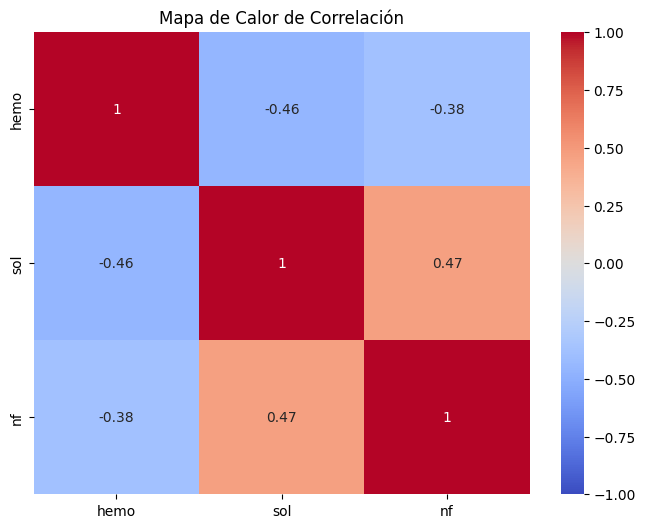

In [19]:
col_num = ['hemo','sol','nf']
correlation_matrix = bert_results[col_num].corr(numeric_only=True, method='pearson')
print("Matriz de Correlación:")
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlación')
plt.show()


In [20]:
print(correlation_matrix)